# Práctica 2: Limpieza y análisis de datos
## Autores
Hemos realizado esta práctica:

* Ignacio Such Ballester
* Andrés Isidro Fonts Santana

## 1. Descripción del _dataset_
### 1.1 Contexto
Se pretende sacar al mercado un nuevo juego de mesa lo más existoso posible y convertirlo en un bestseller.

Para ello, hemos escogido el _dataset_ [Board Game Data](https://www.kaggle.com/datasets/mrpantherson/board-game-data?select=bgg_db_2018_01.csv), disponible en la plataforma Kaggle.

Este conjunto de datos se ha extraído mediante la API del portal [Board Games Geek](https://boardgamegeek.com/). El _dataset_ se generó en enero de 2018 y contiene datos sobre los primeros 5000 juegos de mesa del _ranking_ de Board Games Geek. 

A través de este set de datos, podemos realizar un análisis profundo del mismo, obteniendo correlaciones, clasificaciones en incluso predicciones para averigurar cómo diseñar nuestro juego de mesa.

Además, se podrá proceder a crear modelos de regresión que permitan predecir si un juego será un bestseller o no en función de sus características y contrastes de hipótesis que ayuden a identificar propiedades interesantes en las muestras.

### 1.2 Descripción de los atributos 
Cada uno de los 5000 registros con que cuenta al _dataset_ viene determinado por 20 attributos:

| Nombre      | Tipo    | Descripción                         | Ejemplo
|:------------|:--------|:------------------------------------|:-------------------------------------------------------------
| rank        | int     | Posición en el _ranking_ de BGG     | 21
| bgg_url     | string  | Link a url de la reseña en BGG      | https://boardgamegeek.com/boardgame/167791/terraforming-mars
| game_id     | string  | Identificador del juego en BGG      | 25613
| names       | string  | Nombre del juego                    | Terraforming Mars
| min_players | int     | Número mínimo de jugadores          | 2
| max_players | int     | Número máximo de jugadores          | 4
| avg_time    | int     | Tiempo medio de partida (minutos)   | 60
| min_time    | int     | Tiempo mínimo de partida (minutos)  | 30
| max_time    | int     | Tiempo máx de partida (minutos)     | 120
| year        | int     | Año de publicación                  | 2014
| avg_rating  | float   | Puntuación media del juego según usuarios de BGG (sobre 10)| 8.0096
| geek_rating | float   | Puntuació de BGG, obtenida a través de un algoritmo de ponderación bayesiana (algoritmo no público) |8.49837
| num_votes   | int     | Número de usuarios que han dado puntuación al juego | 1779
| image_url   | string  | Enlace a la imagen del juego  | https://cf.geekdo-images.com/images/pic361592.jpg
| age         | int     | Edad mínimia recomendada | 12
| mechanic    | string  | Tipo de Mecánicas del juego, separadas por comas | Area Enclosure, Card Drafting, Hand Management, Variable Player Powers, Worker Placement
| owned       | int     | Número de usuarios de BGG que han notificado que poseen el juego | 18217
| category    | string  | Categorías a las que pertenece el juego, separadas por comas | Ancient, Card Game, City Building, Civilization
| designer    | string  | Diseñador/a del juego. Si más de uno, separados por comas | Jamey Stegmaier
| weight      | float   | Grado de complejidad del juego (escala de 1 a 5) | 2.394


## 2. Carga de datos y selección
Utilizaremos la librería `pandas` para trabajar con los datos así como `plotly` para realizar gráficos.

In [2]:
import pandas as pd
from IPython.display import display, HTML
import numpy as np

# Importamos plotly y también lo asignamos como backend de pandas plot.
import plotly.express as px
pd.options.plotting.backend = "plotly"

# Llamamos "bgg" al dataframe creado a partir del dataset
bgg = pd.read_csv('../csv/bgg_db_2018_01.csv',sep=',',encoding='latin-1')

Veamos qué aspecto tienen los datos, utilizando `.head()`.

In [3]:
bgg.head(5)

,rank,bgg_url,game_id,names,min_players,max_players,avg_time,min_time,max_time,year,avg_rating,geek_rating,num_votes,image_url,age,mechanic,owned,category,designer,weight
0,1,https://boardgamegeek.com/boardgame/174430/glo...,174430,Gloomhaven,1,4,150,90,150,2017,9.01310,8.52234,9841,https://cf.geekdo-images.com/images/pic2437871...,12,"Action / Movement Programming, Co-operative Pl...",18217,"Adventure, Exploration, Fantasy, Fighting, Min...",Isaac Childres,3.7720
1,2,https://boardgamegeek.com/boardgame/161936/pan...,161936,Pandemic Legacy: Season 1,2,4,60,60,60,2015,8.66575,8.49837,23489,https://cf.geekdo-images.com/images/pic2452831...,13,"Action Point Allowance System, Co-operative Pl...",38105,"Environmental, Medical","Rob Daviau, Matt Leacock",2.8056
2,3,https://boardgamegeek.com/boardgame/182028/thr...,182028,Through the Ages: A New Story of Civilization,2,4,240,180,240,2015,8.65702,8.32401,10679,https://cf.geekdo-images.com/images/pic2663291...,14,"Action Point Allowance System, Auction/Bidding...",14147,"Card Game, Civilization, Economic",Vlaada Chvátil,4.3538
3,4,https://boardgamegeek.com/boardgame/12333/twil...,12333,Twilight Struggle,2,2,180,120,180,2005,8.35188,8.21012,29923,https://cf.geekdo-images.com/images/pic361592.jpg,13,"Area Control / Area Influence, Campaign / Batt...",41094,"Modern Warfare, Political, Wargame","Ananda Gupta, Jason Matthews",3.5446
4,5,https://boardgamegeek.com/boardgame/167791/ter...,167791,Terraforming Mars,1,5,120,120,120,2016,8.38331,8.17328,20468,https://cf.geekdo-images.com/images/pic3536616...,12,"Card Drafting, Hand Management, Tile Placement...",26145,"Economic, Environmental, Industry / Manufactur...",Jacob Fryxelius,3.2465


Constatamos que los atributos `bgg_url` y `image_url` no nos van a ninguna información relevante al estudio que queremos realizar sobre los datos. 

Eliminamos estos datos usando el método `.drop()`. 

In [4]:
# Eliminamos las columnas que no utilizaremos para el análisis
bgg.drop('bgg_url'  , inplace=True, axis=1)
bgg.drop('image_url', inplace=True, axis=1)

Por otro lado, según la documentación de BoardGameGeek, para evaluar el _ranking_ global del juego se utiliza el atributo `geek_rating`. Este atributo realiza una ponderación Bayesiana utilizando un algoritmo que BGG no publica.

Sí sabemos que en este algoritmo se compensan aquellos juegos con pocas valoraciones, pudiendo añadir hasta 100 votos _virtuales_ (ver [este enlace](https://boardgamegeek.com/wiki/page/BoardGameGeek_FAQ#toc13)).

Para nuestro estudio, partiremos de aquellos datos que tengan como mínimo 500 valoracion de usuarios.

In [5]:
# Filtrar por mínimo de votos
bgg = bgg[bgg.num_votes > 500]

## 3. Limpieza de los datos
### 3.1 Valores nulos, ceros y elementos vacíos
En primer lugar, revisamos si existens valores nulos o elementos vacíos. Utilizaremos el método `isnull()` para determinar si un dato es nulo, y posteriormente `.sum()` para contar cuantos elementos nulos entontramos en cada atributo.

In [6]:
# Muestra elementos "null" de nuestro conjunto de datos bgg
bgg.isnull().sum()

rank           0
game_id        0
names          0
min_players    0
max_players    0
avg_time       0
min_time       0
max_time       0
year           0
avg_rating     0
geek_rating    0
num_votes      0
age            0
mechanic       0
owned          0
category       0
designer       0
weight         0
dtype: int64

En el conjunto de datos `bgg` no observamos valores nulos.

Los valores nulos podrían estar representados también como valores "cero". Con `.describe()` obtendremos un resumen de nuestro _dataset_ y podremos identificar artributos con valores "cero".

In [29]:
# Muestra valores con .describe(), redondeando a dos decimales
bgg.describe(percentiles=[0.5]).round(2)

,rank,game_id,min_players,max_players,avg_time,min_time,max_time,year,avg_rating,geek_rating,num_votes,age,owned,weight
count,2718.00,2718.00,2718.00,2718.00,2718.00,2718.00,2718.00,2718.00,2718.00,2718.00,2718.00,2718.00,2718.00,2718.00
mean,1540.53,76941.62,2.07,5.21,86.58,67.60,86.42,1998.29,6.92,6.35,3270.87,10.53,4797.86,2.29
std,1079.07,71016.34,0.69,6.16,294.61,142.75,294.64,147.44,0.55,0.50,5778.33,2.70,7815.35,0.77
min,1.00,1.00,1.00,1.00,1.00,0.00,0.00,-3000.00,5.77,5.64,501.00,0.00,458.00,0.00
50%,1364.50,46110.00,2.00,4.00,60.00,45.00,60.00,2009.00,6.88,6.24,1395.50,10.00,2370.00,2.23
max,4987.00,236191.00,8.00,99.00,12000.00,6000.00,12000.00,2017.00,9.07,8.52,74261.00,18.00,106608.00,4.70


Aquí se puede ver que para algunas observaciones encontramos juegos que tienen valores "cero", como son en las variables `min_players`, `max_players`, `avg_time`, `min_time`, `max_time`, `age` y `weight`.

#### 3.1.1 Variable `min_players`
Empezemos analizando qué datos corresponden a `min_players = 0`.

In [21]:
# Mostramos aquellos registros en que la variable min_players = 0
bgg[bgg['min_players']==0][['names', 'min_players', 'max_players', 'avg_time', 'min_time', 'max_time', 'year','age']]

,names,min_players,max_players,avg_time,min_time,max_time,year,age
2164,Unpublished Prototype,0,0,0,0,0,0,0
2475,Outside the Scope of BGG,0,0,0,0,0,0,0
2523,Traditional Card Games,0,0,0,0,0,0,0


Por el nombre del juego entendemos que estos registros corresponden a reseñas "genéricas" publicadas en el portal Board Game Geek, no se trata de juegos de mesa reales. De hecho los registros `min_players`, `max_players`, `avg_time`, `min_time`, `max_time`, `year` y `age` son todos `0`.

Decidimos retirar estos registros de nuestro conjunto de datos.

In [22]:
# Eliminamos los registros que corresponden a min_players = 0
bgg = bgg[bgg['min_players']!=0]

Volvamos a comprobar nuestros datos:

In [30]:
bgg[['max_players', 'avg_time', 'min_time', 'max_time', 'weight','age']].describe(percentiles=[0.5]).round(2)

,max_players,avg_time,min_time,max_time,weight,age
count,2718.00,2718.00,2718.00,2718.00,2718.00,2718.00
mean,5.21,86.58,67.60,86.42,2.29,10.53
std,6.16,294.61,142.75,294.64,0.77,2.70
min,1.00,1.00,0.00,0.00,0.00,0.00
50%,4.00,60.00,45.00,60.00,2.23,10.00
max,99.00,12000.00,6000.00,12000.00,4.70,18.00


Quedan por analizar los valores cero de los atributos `min_time`, `max_time`, `age` y `weight`.

#### 3.1.2 Variable `min_time`
Veamos qué registros presentan `min_time = 0`.

In [33]:
bgg[bgg['min_time']==0][['names', 'min_time', 'max_time', 'avg_time']]

,names,min_time,max_time,avg_time
567,Telestrations: 12 Player Party Pack,0,30,30
893,Kodama: The Tree Spirits,0,40,40
1056,Adventure Time Love Letter,0,20,20
1252,Smash Up: Cease and Desist,0,45,45
3092,Sequence,0,30,30


En estos registros no consta el valor `min_time`. En este caso asumiremos que `min_time = max_time`. Corregimos estos registros.

In [34]:
# Sustituimos los valores '0' por el valor max_time
bgg['min_time'].where(bgg['min_time']!=0, bgg['max_time'], inplace=True)

#### 3.1.3 Variable `max_time`
Comprobemos los registros `max_time = 0`.

In [38]:
bgg[bgg['max_time']==0][['names','min_time','max_time','avg_time']].head(5)

,names,min_time,max_time,avg_time
790,Ice Cool,20,0,20
799,Dungeons & Dragons Dice Masters: Battle for Fa...,60,0,60
1359,Capital Lux,30,0,30
1478,Spyfall 2,10,0,10
1802,Smash Up: Munchkin,45,0,45


Como hemos realizado con `min_time`, asumiremos que `max_time = min_time` para todo `max_time = 0`.   

In [39]:
bgg['max_time'].where(bgg['max_time']!=0, bgg['min_time'], inplace=True)

#### 3.1.4 Variable `age`
Revisemos ahora la variable `age` en el caso `age = 0`.

In [48]:
bgg[bgg['age']==0][['names','age']].shape

(54, 2)

Un total de 54 registros presentan `age = 0`. En este caso consideramos que el valor se desconoce, así que le asignaremos el valor vacío, reemplazando el valor `0`.

In [49]:
bgg['age'].where(bgg['age']!=0, None, inplace=True)

#### 3.1.5 Variable `weight`
Finalmente revisemos `weight = 0`.

In [50]:
bgg[bgg['weight']==0][['names','weight']]

,names,weight
1252,Smash Up: Cease and Desist,0.0


Asumiremos pues que el valor de weight se desconoce. Por tanto retiraremos este registro del _dataset_. Consideramos que el grado de complejidad es una variable a tener en cuenta en nuestro estudio. No disponer de este dato impide realizar el estudio completo.

In [51]:
# Eliminamos los registros que corresponden a weight = 0
bgg = bgg[bgg['weight']!=0]

#### 3.1.6 Valores nulos en Mecánicas y Categorías 
Durante el análisis previo del _dataset_ observamos que la la cadena de caracteres `none` describe los valores nulos en los atribuots `mechanic` y `owned`.

Veamos un ejemplo:

In [54]:
mchnc_none = bgg['mechanic'] == "none"
ctgry_none = bgg['category'] == "none"

bgg[mchnc_none | ctgry_none][['names','mechanic','category']].head(3)

,names,mechanic,category
171,Trickerion: Legends of Illusion,"Action / Movement Programming, Action Point Al...",none
510,Hawaii,"Action Point Allowance System, Area Movement, ...",none
527,KLASK,none,Action / Dexterity


Reemplazamos el _string_ `"none"` por el valor nulo `None`.

In [55]:
from numpy import nan

bgg[ctgry_none] = bgg[ctgry_none].replace("none", nan)
bgg[mchnc_none] = bgg[mchnc_none].replace("none", nan)

### 3.2 Análisis de valores extremos
Tras haber tratado los valores nulos, volvamos a revisar las estadísticas sobre nuestro _dataset_. Si revisamos las tablas `.describe()` de los apartado anteriores encontramos que los atributos `min_players`, `max_players`, `avg_time`, `min_time`, `max_time` y `year` presentan valores extremos.

#### 3.2.1 Valores extremos de `min_players` y `max_players` 
Empecemos analizando los valores extremos de las variables `min_players` y `max_players`.

In [62]:
px.histogram(bgg, x="min_players", height=400)

In [63]:
px.histogram(bgg, x="max_players", height=400)

In [71]:
bgg[bgg.min_players > 4][['names','min_players','mechanic','category']].head(3)

,names,min_players,mechanic,category
77,The Resistance: Avalon,5,"Memory, Partnerships, Simultaneous Action Sele...","Bluffing, Card Game, Deduction, Fantasy, Medie..."
159,The Resistance,5,"Partnerships, Simultaneous Action Selection, V...","Bluffing, Deduction, Negotiation, Party Game, ..."
204,Secret Hitler,5,"Partnerships, Player Elimination, Voting","Bluffing, Card Game, Deduction, Humor, Party G..."


In [72]:
bgg[bgg.max_players > 12][['names','max_players','mechanic','category']].head(3)

,names,max_players,mechanic,category
277,Time's Up! Title Recall!,18,"Acting, Memory, Partnerships","Humor, Movies / TV / Radio theme, Party Game"
370,Time's Up!,18,"Acting, Memory, Partnerships","Humor, Party Game"
494,Monikers,20,"Acting, Card Drafting, Role Playing","Card Game, Humor, Mature / Adult, Party Game, ..."


Observamos que estos juegos con valores extremos en `min_players` o `max_players` corresponden en su mayoría a juegos de tipo colaborativo, grupales o participativos, que requieren de un mínimo necesario de jugadores y pueden no especificar un número máximo.

Estos valores extremos no son pues erróneaos, por lo que no modificaremos estos valores, pero tendremos en cuenta este análisis en caso necesario.

#### 3.2.2 Valores extremos de `min_time`, `max_time` y `avg_time`
A continuación evaluemos los valores extremos de los atributos que hacen referencia a la duración de las partidas. Empezemos observando la distribución de `min_time` para juegos que tengan una duración superior al percentil 75.

In [77]:
perc75 = bgg.min_time.quantile(.75)
px.histogram(bgg[bgg.min_time > perc75], x="min_time", height=400)

Son pocos los juegos que presentan una duración mínima superior a 500 minutos. Revisemos algunos de estos valores extremos.

In [78]:
bgg[bgg.min_time > 500][['names','min_time','mechanic','category']].head(3)

,names,min_time,mechanic,category
848,Europe Engulfed,720,"Action Point Allowance System, Area Movement, ...","Wargame, World War II"
880,The Civil War,1200,"Dice Rolling, Hex-and-Counter, Simulation","American Civil War, Civil War, Post-Napoleonic..."
930,Empires in Arms,6000,"Area Movement, Dice Rolling, Secret Unit Deplo...","Economic, Napoleonic, Negotiation, Political, ..."


Hemos complementado el análisis de nuevo realizando una búsqueda en BoardGameGeek de estos juegos para comprender mejor los datos.

Estos son juegos de tipo estratégico, de campaña o _legacy_. Son juegos cuyas partidas son muy largas (llegando a durar decenas de partidas). Estos valores extremos pues son correctos, no se trata de errores en el database.

Tendremos en cuenta este tipo de datos al realizar el análisis.

Analizando `min_time` observamos que también son juegos con un `max_time` muy elevado.

#### 3.2.3 Valores extremos de `year`
Finalmente revisemos el atributo `year`, representando la distribución del primer percentil 5%.

In [79]:
px.histogram(bgg[bgg.year < bgg.year.quantile(0.05)], x='year', height=400)

Revisemos algunos de los datos de los juegos publicados antes de 1800.

In [84]:
bgg[bgg.year < 1800][['names','year']].head(5)

,names,year
112,Go,-2200
412,Chess,1475
551,Cribbage,1630
988,Xiangqi,762
1079,Shogi,1000


Comprobamos que se trata de juegos clásicos o históricos, como puede ser el ajedrez o el backgammon. La fecha es pues una aproximación según el conocimiento que se tenga del juego.

Los valores `year = 0` sí corresponden a un valor desconocido del año de publicación (ver Carrom, por ejemplo). Asignaremos el varlos `None` como hemos realizado en el apartado de gestión de valores vacíos. 

In [85]:
# Sustituimos los valores '0' por None
bgg['year'].where(bgg['year']!=0, None, inplace=True)

#### 3.2.5 Cálculo correcto de `avg_time`
Realizando el análisis de los datos hemos observado que la variable `avg_time` es en todos los casos igual a `max_time`. Vamos a recalcular esta variable de manera que

$time_{avg} = \frac{time_{max} + time_{min}}{2}$

In [86]:
bgg.avg_time = (bgg.max_time + bgg.min_time) / 2

## 4. Análisis de los datos
### 4.1 Matriz de Correlación
Tras haber limpiado los datos revisemo la matriz de correlación. Utilizaremos la librería `seaborn` y `matplotlib`.

<AxesSubplot:>

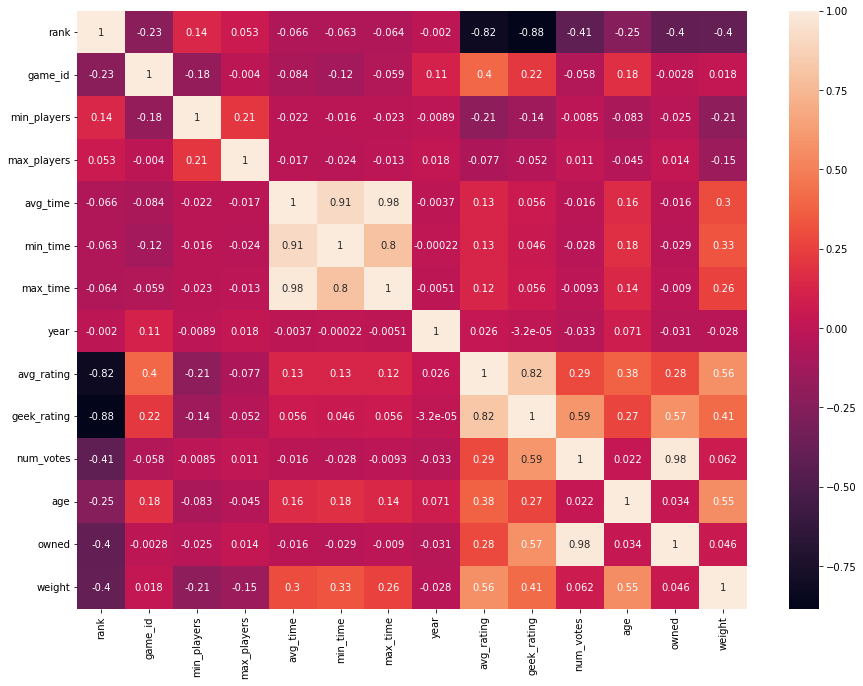

In [87]:
import seaborn as sns
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(15,11)) 

# Calculamos la matriz de correlación
corr = bgg.corr()

# Representamos la matriz de correlación
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

En primer lugar observamos una fuerte correlación entre `avg_time`, `min_time` y `max_time`. Esto es de esperar dada la forma en que hemos calculado `avg_time`. También es lógica la correlación entre `min_time` y `max_time`, relación que ya hemos notado en el apartado de limpieza de los datos.

Por otro lado es notable la relación entre `geek_rating` y `avg_rating`. Dado que `geek_rating` se calcula con un algoritmo y considera `avg_rating` como uno de los _inputs_ esta correlación también es esperable.

También observamos correlación entre la complejidad (`weight`) el el tiempo de duración de la partida. Posiblemente a mayor complejidad mayor tiempo requerido para jugar al juego.

Comentar también que hay una correlación entre `weight` y `age`. De nuevo, parece lógico pensar que a mayor complejidad también la edad mínima requerida pueda ser más elevada.

A continuación analizaremos qué parámetro es más adecuado para determinar la **popularidad** de un juego. Vemos que el atributo `owned` y `num_votes` tienen una fuerte correlación. Analicemos ambas variables con detalle.

### 4.2 Popularidad de un juego
Queremos comprender qué métrica podemos usar para considerar que un juego es **popular**. Disponemos de la variable `owned`, que indica el número de usuarios que han notificado que poseen el juego.

A partir de la matriz de correlación es comprensible asumir que los juegos que tengan más votos de los usuarios (`num_votes`) puedan ser también juegos más populares. 

Por otro lado, el hecho de que un juego tenga un `avg_rating` menor o mayor no necesariamente indica que sea popular. Podemos encontrar juegos de muchísima calidad y con una puntuación elevada, pero que no sea asequible (por precio, complejidad, mecánica, etc) a la mayoría del público.

Veamos la relación entre `owned` y `num_votes`. Analicemos en primer lugar la **homocedasticidad** entre ambos atributos. Utilizaremos la Prueba de Levene, disponible en la librería `scipy`.

In [91]:
from scipy.stats import levene

df = bgg['owned']
norm_rating = (df - df.min()) / (df.max() - df.min())

df2 = bgg['num_votes']
norm_votes = (df2 - df2.min()) / (df2.max() - df2.min())

stat, p = levene(norm_rating, norm_votes)

print("p-value = ", round(p,5))

p-value =  0.44065


El _p-value_ es mayor que el nivel de significancia $\alpha = 0.05$, luego ambas variables son aptas para elaborar un modelo de regresión.

Representemos `owned` vs `num_votes`. Añadiremos pues una recta de regresión sobre los datos, coloreando cada _data point_ según su `avg_rating`.

In [92]:
fig_2 = px.scatter(bgg, x='owned', y='num_votes', trendline='ols', log_x=True, log_y=True,
                   color='avg_rating', title="Relación entre Número de votos y Usuarios que tienen el juego",
                   labels = {
                     "owned": "Usuarios que tienen el juego (owned)",
                     "num_votes": "Usuarios que han valorado el juego (num_votes)"
                 })
fig_2.show()

# Obtenemos el factor R2 que indica la bondad de la regresión:
r_squared = px.get_trendline_results(fig_2).px_fit_results.iloc[0].rsquared
print("El valor R squared es: ", round(r_squared,3))

El valor R squared es:  0.967


La bondad del ajuste según el parámetro $R^2$ es $R^2 = 0.967$, luego la recta de regresión se ajusta muy bien a los datos de la curva `num_votes` vs `owned`.

Consideraremos entonces que `num_votes` es un indicador de la **popularidad** que tiene un juego. Podremos también comparar si es necesario con `owned`, pese a que no esperaremos obtener resultados muy diferentes.


### 4.3 Análisis de la Valoración Media `avg_rating` 
La valoración media de los usuarios tiene cierto grado de correlación con `num_votes`. También `geek_rating` tiene una correlación elevada, pero siendo esta una variable calculada y desconociendo el método de cálculo nos centramos en la valoración media dada por los usuarios.

El análisis de `num_votes` nos ayudará a acotar el espacio de diseño de nuestro juego de mesa.

Comprobemos con el test de _Shapiro-Wilk_ la normalidad de esta distribución. Hemos consultado en la documentación de `plotly` (ver [este enlace](https://plotly.com/python/v3/normality-test/)) cómo utilizar la librería `scipy` para realizar el análisis. 

In [99]:
# Importamos la librería scipy.stats
from scipy.stats import shapiro

# Realizamos el test de shapiro, guardando el resultado en las variables stat y p
stat, p = shapiro(bgg['avg_rating'])

print("p-value = ", p)

p-value =  1.086880596543841e-15


Del análisis de normalidad obtenemos que la variable `avg_rating` **no sigue una distribución normal**, pues el p-valor es inferior a 0.05.

A continuación obtengamos la distribución de `avg_rating` con respecto a `num_votes`. Realizamos un histograma así como un gráfico cumulativo.

In [103]:
px.histogram(bgg, x="avg_rating", y="num_votes", marginal="box", histfunc="sum", hover_data=bgg.columns, height=450)

In [102]:
# Obtengo variables avg_rating y num_votes
df = bgg[['avg_rating','num_votes']]

# Ordeno por avg_rating
df = df.sort_values(by='avg_rating')

# Calculo suma cumulativa
df['votes_cumsum'] = df['num_votes'].cumsum()

px.scatter(df, x='avg_rating', y='votes_cumsum', marginal_x='box', marginal_y='box', height=400)

A partir de los gráficos anteriores centraremos nuestra atención en aquellos juegos que han obtenido un `avg_rating` mínimo de 6.5 (corresponde al percentil 25) y como máximo un `avg_rating` de 8 (valor a partir del cual apenas se incrementa la suma cumulativa de `num_votes`).

In [104]:
min_rating = 6.5
max_rating = 8.0

df_game = bgg[(bgg['avg_rating'] > min_rating) & (bgg['avg_rating'] < max_rating)]

De esta manera conseguimos acotar nuestro conjunto de datos para estudiar aquellos juegos más populares.

Si sobre estos datos representamos la distribución de `num_votes`:

In [107]:
px.scatter(df_game, x="num_votes", y="avg_rating", log_x=True, marginal_x="box", title="Distribución de num_votes", height=450)

Acotaremos finalmente nuestro juego de datos para aquellos juegos que pertenecen al percentil 25 superior. Estos corresponden a los juegos que han tenido más popularidad, tras haber estudiado la relación con `avg_rating`.

In [108]:
perc75 = df_game['num_votes'].quantile(0.75)

df_game = df_game[df_game['num_votes'] >= perc75]

### 4.4 Categorías de Juegos de Mesa
Queremos ver cúales son las temáticas o categorías que más juegos hay en el mercado, para de este modo saber las tendencias tanto actuales como pasadas. De este modo, podemos ver cuáles podrían ser las posibles oportunidades de negocio a la hora de crear nuestro juego de mesa.

El análisis de las categorías de los juegos de mesa con un alto número de votos, nos dará una mejor visión sobre los juegos de mesa más comprados y valorados.

In [114]:
# Separamos las categorías de cada observación y se cuentan el total de cada una de ellas.
cat = df_game.category.str.get_dummies(', ').stack().sum(level=1)

# Ordenamos dichas categorías y las mostramos por pantalla.
px.bar(cat.sort_values(ascending = False).head(20), title="Top 25 - Categorías de juegos de mesa", height=420,
      labels = {
          "index" : "Categorías de Juegos de mesa (category)",
          "value" : "Frecuencia (count)"
      })

C:\Miniconda3\envs\boardgame\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().



Vemos que de las 5 categorías más populares son `Card Game`, `Fantasy`, `Fighting`, `Economic` y `Science Fiction`.

La categoría más frecuentre entre los juegos más populares es `Card Game`, por lo que podría ser un comienzo sobre el tipo de juego que queremos crear o el enfoque a dar.
### 4.5 Mecánicas de Juegos de Mesa 
Por otro lado analizamos las mecánicas más empleadas. Así conoceremos los estilos de juegos favoritos de la comunidad.

In [115]:
# Separamos las mecánicas de cada observación y se cuentan el total de cada una de ellas.
mech = df_game.mechanic.str.get_dummies(', ').stack().sum(level=1)

# Ordenamos dichas categorías y las mostramos por pantalla.
px.bar(mech.sort_values(ascending = False).head(20), title="Top 25 - Mecánicas de juegos de mesa", height=420,
      labels = {
          "index" : "Mecánicas de Juegos de mesa (category)",
          "value" : "Frecuencia (count)"
      })

C:\Miniconda3\envs\boardgame\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().



Vemos que los más jugados son `Hand Management`, `Dice Rolling`, `Variable Player Powers`, `Set Collection` y `Card Drafting`. 




### 4.6 Duración media del juego
Podemos evaluar también qué duración de partida podríamos esperar de nuestro juego de mesa. Analizamos `avg_time`.

In [116]:
px.histogram(df_game, x="avg_time", nbins=35, title="Distribución de Duración media del juego", height=400,
             labels={
                 "avg_time":"Duración Media del Juego",
                 "count":"Frecuencia (count)"
             })

Considermaos que el juego debería tener una duración entre 30min y 100min según los datos analizados.
### 4.7 Número de jugadores
Evaluamos también el número de jugadores recomendado. Analizamos `min_players` y `max_players`.

In [118]:
px.histogram(df_game, x="min_players", nbins=10, title="Distribución de Número mínimo jugadores", height=400,
             labels={
                 "min_players":"Número mínimo de jugadores",
                 "count":"Frecuencia (count)"
             })

In [119]:
px.histogram(df_game, x="max_players", nbins=100, title="Distribución de Número máximo jugadores", height=400,
             labels={
                 "max_players":"Número máximo de jugadores",
                 "count":"Frecuencia (count)"
             })

Nuestro juego de mesa deberá poderse jugar entre 2 y hasta 6 jugadores.

### 4.8 Edad mínimia recomendada y complejidad del juego
Finalmente veamos la edad mínima recomendada así como el grado de complejidad con que diseñar el juego.

In [120]:
px.histogram(df_game, x="age", nbins=10, title="Distribución de Edad mínima recomendada", height=400,
             labels={
                 "age":"Edad mínima recomendada",
                 "count":"Frecuencia (count)"
             })

Según BGG se utilizan 5 niveles de complejidad:
* Light (1)
* Medium Light (2)
* Medium (3)
* Medium Heavy (4)
* Heavy (5)

In [121]:
px.histogram(df_game, x="weight", nbins=10, title="Distribución de Complejidad del juego", height=400,
             labels={
                 "weight":"Nivel de Complejidad",
                 "count":"Frecuencia (count)"
             })

Según estos datos el nivel de complejidad debe encontrarse entre ligeramente superior a  Light (1) y no superior a Medium (3).

### 4.10 Exportación del CSV final

Exportamos a un csv el dataset final analizado y lo llamammos `games_final.csv`

In [122]:
df_game.to_csv('../csv/games_final.csv')

# 5. Resolución del problema y conclusiones
Hemos querido analizar este conjunto de datos para determinar el espacio de diseño de un nuevo juego de mesa para maximizar su popularidad. Para lograrlo, hemos preparado el conjunto de datos adecuadamente y analizado las variables más representativas.

Hemos decidido usar `num_votes` como índica de popularidad y tras acotar el _dataset_ hemos analizado los diferentes atributos para determinar el espacio de diseño de nuestro juego de mesa:

| Atributo | Espacio de solución
|--------:|:------------------
|Duración de la partida | Entre 30 y 100 minutos
|Número de jugadores | Entre 2 y 6 jugadores
|Duración de la partida | Entre 30 y 100 minutos
|Edad mínima recomendada| 10 años
|Categorías | Card Game, Fantasy, Fighting, Economic y Science Fiction
|Mecánicas | Hand Management, Dice Rolling, Variable Player Powers, Set Collection y Card Drafting

## 5.1 Ejemplo de espacio de diseño del juego de mesa
A modo de ejemplo, podríamos ambientar un **juego de cartas** (_Card Game_) en un futuro distópico (_Science Fiction_) en que diferentes razas (clásico en los géneros de _Fantasy_, por ejemplo, humanos terrícolas, humanos marcianos, alienígenas, mutantes, cyborgs y la IA) compiten por los recursos del Sistema Solar (_Economy_) por lo que tendrán que forjar alianzas, comerciar a la par que luchar por el domino del Sistema (_Fighting_).

Las razas poseerán habilidades completamente diferentes (_Variable Player Powers_), que podrán ser potenciadas mediante la colección de su recurso más preciado (_Set Collection_), como puede ser el agua para los terrícolas y los marcianos, la materia oscura para los alienígenas, el uranio para los mutantes, el oxígeno para los cybors y el silicio para la IA (Inteligencia Artificial).

Las acciones a realizar (por ejemplo: comerciar, espiar o batallar) en cada turno dependerán del uso de la manos de cartas de cada jugador (_Hand Management_), que irá alimentándose (_Card Drafting_) cada inicio de turno según su desarrollo como raza y su dominio sobre el Sistema.

Cada turno ser verá afectado por una catastrofe natural o cataclismo cósmico de consecuencias imprevisibles. El azar (_Dice Rolling_) determinará si eventos como una explosión solar, el impacto de un meteorito el cambio abrupto del campo magnético de la Tierra devastan los recursos de cada raza.

# 6. Tabla de Contribuciones
Las contribuciones de Ignacio Such constan como IS, las de Andrés Fonts como AF.

|Contribuciones|Firma
|:-:|:-:|
|Investigación previa| IS, AF
|Redacción de las respuestas|IS, AF
|Desarrollo del código| IS, AF

## Referencias consultadas


Board Game Rank \[en línea\] \[fecha de consulta: 30 de mayo de 2022\]. Disponible en: https://boardgamegeek.com/browse/boardgame?sort=rank&sortdir=desc

BoardGameGeek FAQ \[en línea\] \[fecha de consulta: 31 de mayo de 2022\]. Disponible en: https://boardgamegeek.com/wiki/page/BoardGameGeek_FAQ#toc13

BoardGameWiki. Weight \[en línea\] \[fecha de consulta: 31 de mayo de 2022\]. Disponible en: https://boardgamegeek.com/wiki/page/Weight

How to delete a column in pandas \[en línea\] \[fecha de consulta: 01 de junio de 2022\]. Disponible en: https://www.educative.io/edpresso/how-to-delete-a-column-in-pandas

Pandas Plotting Backend in Python \[en línea\] \[fecha de consulta: 02 de junio de 2022\]. Disponible en: https://plotly.com/python/pandas-backend/

Working with Markdown tables in GitHub \[en línea\] \[fecha de consulta: 03 de junio de 2022\]. Disponible en: https://www.pluralsight.com/guides/working-tables-github-markdown

Practical Business Python. Overview of Pandas Data Types \[en línea\] \[fecha de consulta: 3 de junio de 2022\]. Disponible en: https://pbpython.com/pandas_dtypes.html

Setting the Font, Title, Legend Entries, and Axis Titles in Python \[en línea\] \[fecha de consulta: 3 de junio de 2022\]. Disponible en: https://plotly.com/python/figure-labels/

Plotly Documentation. plotly.express.histogram \[en línea\] \[fecha de consulta: 3 de junio de 2022\]. Disponible en: https://plotly.github.io/plotly.py-docs/generated/plotly.express.histogram.html

Plotly Documentation. Normality Tests in Python/v3 \[en línea\] \[fecha de consulta: 3 de junio de 2022\]. Disponible en: https://plotly.com/python/v3/normality-test/

Stackoverflow. Correlation heatmap \[en línea\] \[fecha de consulta: 3 de junio de 2022\]. Disponible en: https://stackoverflow.com/questions/39409866/correlation-heatmap

Seaborn Documentation. seaborn.heatmap \[en línea\] \[fecha de consulta: 3 de junio de 2022\]. Disponible en: https://seaborn.pydata.org/generated/seaborn.heatmap.html

Box Plots in Python \[en línea\] \[fecha de consulta: 6 de junio de 2022\]. Disponible en: https://plotly.com/python/box-plots/

Subplots in Python \[en línea\] \[fecha de consulta: 6 de junio de 2022\]. Disponible en: https://plotly.com/python/subplots/

scipy.stats.levene \[en línea\] \[fecha de consulta: 6 de junio de 2022\]. Disponible en: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html